# -Adapt architecture (loss, learning-rate,...)

## Using hinge loss:

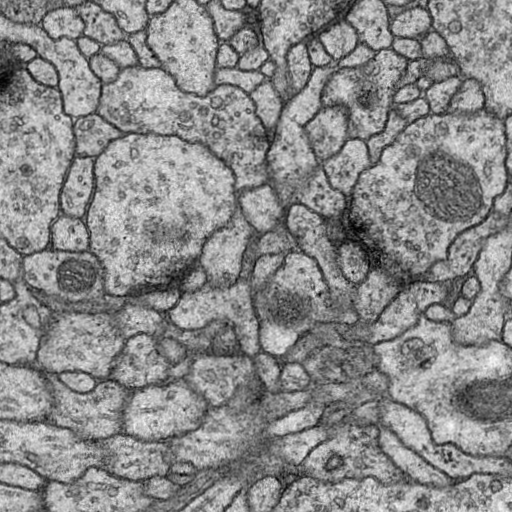

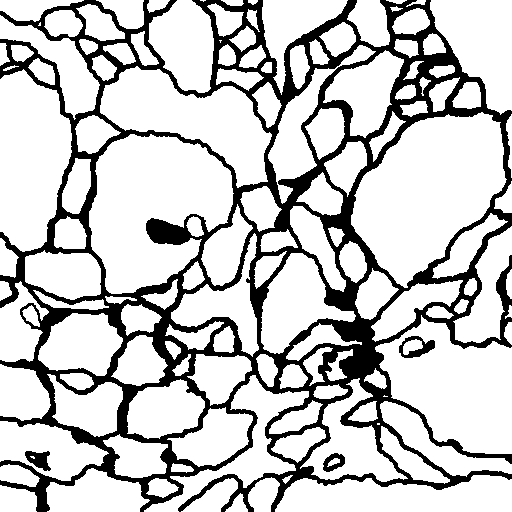

In [1]:
##########################################################
#           In this box some code must be added          #
##########################################################
from IPython.display import Image
#We want to see one of the training data with its label
# Change the folders or the code that the path points to your data
training_images = 'data/Unet/membrane/train/image/'
training_labels = 'data/Unet/membrane/train/label/'

#We use the function Image(file_name) to print the image '0.png' and the label 'o.png'
display(Image(training_images + '0.png'))
display(Image(training_labels + '0.png'))


### Buidling the Unet Architecture

In the next box all libraries and packages we will need for the U-Net and its data prepration will be imported. 
Because Keras is a part of tensorflow and is installed within, it comes preinstalled with tensorflow <br>
"tensorflow.keras"

If something went wrong with importing the packages, you can try to restart your kernel.

In [2]:
from __future__ import print_function
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os 
import glob
import skimage.io as io #pip install scikit-image pip install scipy within your conda environment
# if This Error occurs:
# <<ImportError: cannot import name 'rgb2gray'>>
# restart your kernel
import skimage.transform as trans
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

In [3]:
def dice_coef(y_true, y_pred):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = np.sum(y_true_flatten * y_pred_flatten)
    nominator = 2 * intersection
    denominator = np.sum(y_true_flatten) + np.sum(y_pred_flatten) + K.epsilon()
    coef = nominator/ denominator
    return coef

In [4]:
def dice_coef_loss(y_true, y_pred):
    dice_coef_loss = 1 - dice_coef (y_true, y_pred)
    return dice_coef_loss

In [16]:
##########################################################
#           In this box some code must be added          #
##########################################################

def unet(pretrained_weights=None, input_size=(256, 256, 1)): #the values given for the parameters are the default values
    inputs = Input(input_size)
    # complete the missing layers (your may use the lines below the ones to fill in, if you are stuck)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    #Maxpooling with 2x2
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    
    
    ################################################################################################
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    ################################################################################################
    
    # Here add a Dropout of 0.5
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)
    ################################################################################################
    # Here we will start with the upconvolution 
    ################################################################################################
    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(drop5)
        #____ insert the input of this first upsampling layer with using the function:
        # << UpSampling2D()>> with the same size as the MaxPooling layers and as input the according layer.
        )
    # Because we now have the output of our UpConvolution but also we need the spatial information from the 
    # convolutional layers and MaxPooling we have to merge these two inputs with the function <<concatenate>> 
    # Figurativly speaking merge the gray and green arrows from Fig. 2
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    
    # In the last layer we chose the <sigmoid> as activation function because the output has to be between zero and one.
    # We normalized out pixle values by deviding through 255.
    # For our example we have only one class and thus only needing
    # zero being white (our predicted object-segment) and 1 beeing black. 
    # but if we have more that one class the different colors will also lie inbetween 0 and 1 and every
    # prediction is labeld with the appropriate number. 
    
    # Choose a function for your last layer which fullfill the requirements for classification at its best
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    # With the following method <Model> we define out input and output of or Neural Network
    # please complete:
    model = Model(inputs=inputs, outputs=conv10)

    # with Model.compile we configure and prepare our network for training. Thus we define our optimizer for 
    # learning with it's learning rate, the loss function and the metrics.
    # Choose a loss you think fits best for this kind of task and also do so for the optimizer
    # if your own coded optimizer and loss should be used you have to implement them accoridingly 
    #loss_fn = dice_coef_loss()
    model.compile(optimizer=Adagrad(lr=0.001), loss='hinge', metrics=['accuracy'])

    # model.summary()
    
    # this part we need for resume to a training or printing test, results for an already trained network, be careful
    # that the input_size you defined for the model match with the one you defined for the model you take the pretrained
    # weights from!
    # Here you can play with some provided networks for more difficult tasks and do not train them expensivly on your own 
    # Computer
    if (pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

### Preparing the Data

So far we build the architecture of our neural net and the data, consists out of images and labels. To train the neural network in the next step the data has to be prepared.

First of all we define a color map for our labels. With this map we define a specific mask-color for each of the appearing objects. 
Because we only have one ground truth label, the boundaries of the cell, we do not really need a color map. But as you can use this code for other task and to familiar with such a Color dicitonary some COLOR_DICT is given below.

In [6]:
# this part below assign the labeling color for the predictions to the labels
# for our purpose it is not really important because we only have "unlabelled" labels, but if you want to experiment
# with other data you might can use and easily adapt this
Sky = [128,128,128]
Building = [128,0,0]
Pole = [192,192,128]
Road = [128,64,128]
Pavement = [60,40,222]
Tree = [128,128,0]
SignSymbol = [192,128,128]
Fence = [64,64,128]
Car = [64,0,128]
Pedestrian = [64,64,0]
Bicyclist = [0,128,192]
Unlabelled = [0,0,0]

COLOR_DICT = np.array([Sky, Building, Pole, Road, Pavement, Tree, SignSymbol, Fence, Car, Pedestrian, Bicyclist, Unlabelled])

#### Adjusting the Data

Before we feed the data to our neural network, it has to be adjusted properly. 
The first step always helps is to normalize our input data. Important is to normalize both the labels and the images, so that the neural network does not learn something wrong, warped or even nothing at all.
As said befor this code can also used to implement multiple classes, and therefore needs a flag whether the input is multi class (flag_multi_class = True) or just binary. 
In this tutorial we got the binary case and therefor the images and masks just need to be normalized.
This is done by dividing through 255. 
To get the mask as one-hot vector, we need to convert it. Every mask value > 0.5 should be 1 and every mask value <= 0.5 should be 0. This has to be done below.

In [7]:
##########################################################
#           In this box some code must be added          #
##########################################################
def adjustData(img,mask,flag_multi_class,num_class):
    if(flag_multi_class):
        img = img / 255
        mask = mask[:,:,:,0] if(len(mask.shape) == 4) else mask[:,:,0]
        new_mask = np.zeros(mask.shape + (num_class,))
        for i in range(num_class):
            #for one pixel in the image, find the class in mask and convert it into one-hot vector
            #index = np.where(mask == i)
            #index_mask = (index[0],index[1],index[2],np.zeros(len(index[0]),dtype = np.int64) + i) if (len(mask.shape) == 4) else (index[0],index[1],np.zeros(len(index[0]),dtype = np.int64) + i)
            #new_mask[index_mask] = 1
            new_mask[mask == i,i] = 1
        new_mask = np.reshape(new_mask,(new_mask.shape[0],new_mask.shape[1]*new_mask.shape[2],new_mask.shape[3])) if flag_multi_class else np.reshape(new_mask,(new_mask.shape[0]*new_mask.shape[1],new_mask.shape[2]))
        mask = new_mask
        
    elif(np.max(img) > 1):
        # normalize the image
        img = img / 255
        # normalize the mask 
        mask = mask /255
        # convert your mask vector into a one-hot vector 
        mask[mask > 0.5] = 1 #1-hot vector (True)
        mask[mask <= 0.5] = 0 # 1-hot vector(False)
    return (img,mask)

In [8]:
##########################################################
#           In this box some code must be added          #
##########################################################
#change save_to_dir to your output path if you do not want to save the output of the trainings Generator the path
# is "None"
def trainGenerator(batch_size,train_path,image_folder,mask_folder,aug_dict,image_color_mode = "grayscale",
                    mask_color_mode = "grayscale",image_save_prefix  = "image",mask_save_prefix  = "mask",
                    flag_multi_class = False,num_class = 2,save_to_dir = __,target_size = (256,256),seed = 1):
    '''
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
    train_generator = zip(image_generator, mask_generator)
    # the generated masks and images are now passed on the function <<adjustData>> discussed beforehand
    for (img,mask) in train_generator:
        img,mask = adjustData(img,mask,flag_multi_class,num_class)
        yield (img,mask)
        
# to understand what yield is: https://stackoverflow.com/questions/231767/what-does-the-yield-keyword-do

In [9]:
def testGenerator(test_path,num_image = 30,target_size = (256,256),flag_multi_class = False,as_gray = True):
    for i in range(num_image):
        img = io.imread(os.path.join(test_path,"%d.png"%i),as_gray = as_gray)
        img = img / 255
        img = trans.resize(img,target_size)
        img = np.reshape(img,img.shape+(1,)) if (not flag_multi_class) else img
        img = np.reshape(img,(1,)+img.shape)
        yield img

#### The visualizer of the labels and predictions

In [10]:
def labelVisualize(num_class,color_dict,img):
    img = img[:,:,0] if len(img.shape) == 3 else img
    img_out = np.zeros(img.shape + (3,))
    for i in range(num_class):
        img_out[img == i,:] = color_dict[i]
    return img_out / 255

#### Saving the results

In [11]:
def saveResult(save_path,npyfile,flag_multi_class = False,num_class = 2):
    for i,item in enumerate(npyfile):
        img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
        io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)

## Run the training

In [17]:
##########################################################
#           In this box some code must be added          #
##########################################################
# if it fails to run the training on your tensorflow-gpu 
# rerun it on a tensorflow cpu version

data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGene = trainGenerator(2,'data/Unet/membrane/train','image','label',data_gen_args,save_to_dir = 'data/training_generator', flag_multi_class = False)

model = unet()
model_checkpoint = ModelCheckpoint('unet_membrane.hdf5', monitor='loss',verbose=1, save_best_only=True)
# Try to start your training with x steps per epoch with y epochs
# model.fit_generator(myGene,steps_per_epoch=300,epochs=2,callbacks=[model_checkpoint])
model.fit(myGene,steps_per_epoch=300,epochs=4,callbacks=[model_checkpoint])

Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.
Epoch 1/4
300/300 [==============================] - 2402s 8s/step - loss: 0.6816 - accuracy: 0.7657

Epoch 00001: loss improved from inf to 0.59081, saving model to unet_membrane.hdf5
Epoch 2/4
300/300 [==============================] - 1843s 6s/step - loss: 0.4395 - accuracy: 0.7812

Epoch 00002: loss improved from 0.59081 to 0.43873, saving model to unet_membrane.hdf5
Epoch 3/4
 32/300 [==>...........................] - ETA: 26:18 - loss: 0.4446 - accuracy: 0.7781

KeyboardInterrupt: 

## Test your Model

When the training is done you can generate some prediction on your test data and save them within the test-image folder.

In [18]:
testGene = testGenerator("data/Unet/membrane/test")
results = model.predict(testGene,30,verbose=1)
saveResult("data/Unet/membrane/test",results)

30/30 [==============================] - 26s 870ms/step


<ipython-input-11-e3b5b954b86c>:4: UserWarning: data/Unet/membrane/test/0_predict.png is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-11-e3b5b954b86c>:4: UserWarning: data/Unet/membrane/test/1_predict.png is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-11-e3b5b954b86c>:4: UserWarning: data/Unet/membrane/test/2_predict.png is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-11-e3b5b954b86c>:4: UserWarning: data/Unet/membrane/test/3_predict.png is a low contrast image
  io.imsave(os.path.joi

<ipython-input-11-e3b5b954b86c>:4: UserWarning: data/Unet/membrane/test/29_predict.png is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


### Show the results

We can now either look in the folder how well our network was trained or just show some images and their predicitons here:
If your prediction is just a gray image, your model wasn't trained good enough, and you might want to change some parameters (first of all steps_per_epoch and epochs)

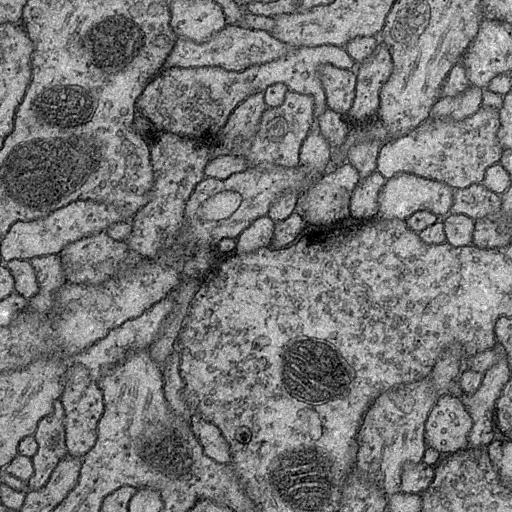

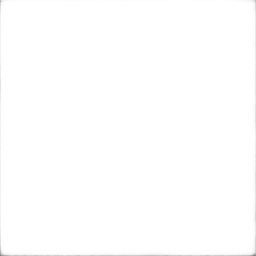

In [19]:
test_images_path = "data/Unet/membrane/test/"
# number 0 to 29 your want to show
img_number = 29
display(Image(test_images_path + str(img_number) + '.png'))
display(Image(test_images_path + str(img_number)  + '_predict.png'))

<span style="color:red;">
The results are unacceptable due to the following reason:

In the previous training binary cross entropy loss was used. A cross entropy loss function is based on a probabilistic decision. It has some computational difficulties, but the accuracy achieved is good.

In this training here, hinge loss was used. It is based on penalising the wrong predictions and lessconfident predictions. Here the accuracy achieved is less but it is computationally very efficient. For this application 
here, cross entropy loss has proved to be better. 
    
    
</span>

# -Try on dataset with multiple labels

# Kitti dataset:
Available from: http://www.cvlibs.net/datasets/kitti/eval_semseg.php?benchmark=semantics2015

Tried on kitti data set and got this  incompatible size error

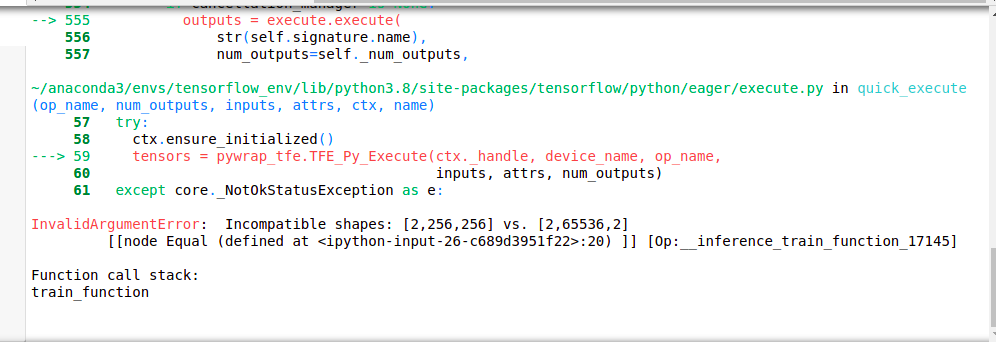

In [20]:
display(Image('multiclass.png'))

# -Try on zebrafish repository

# Error: Unable to load the image files

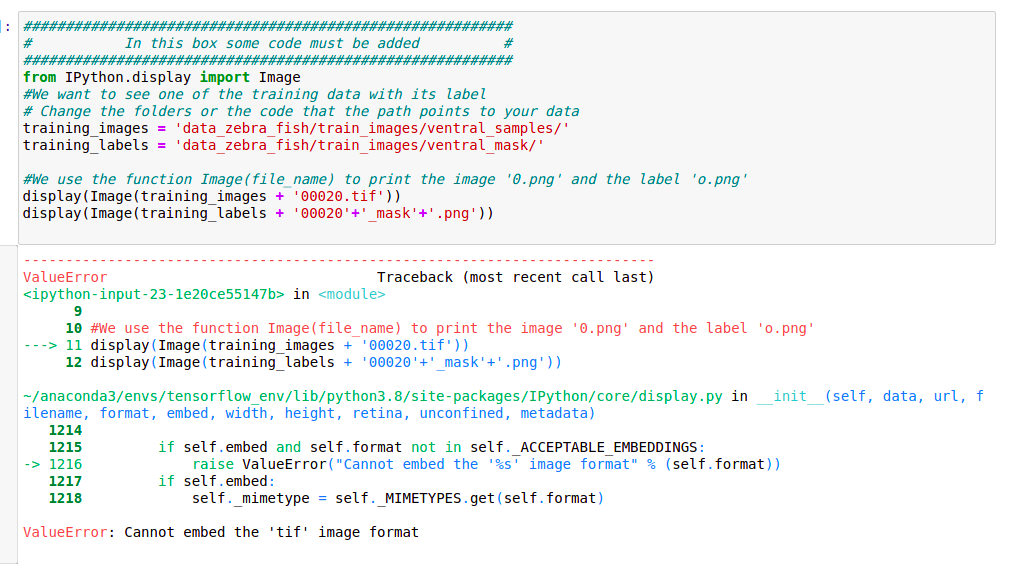

In [21]:
display(Image('zebrafish.png'))